In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
from skimage import io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

Downloading: "https://www.cellpose.org/models/cyto_0" to C:\Users\lukasvandenheu\.cellpose\models\cyto_0
100%|█████████████████████████████████████████████████████████████████████████████| 25.2M/25.2M [00:01<00:00, 13.4MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to C:\Users\lukasvandenheu\.cellpose\models\cyto_1
100%|█████████████████████████████████████████████████████████████████████████████| 25.2M/25.2M [00:02<00:00, 11.4MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to C:\Users\lukasvandenheu\.cellpose\models\cyto_2
100%|█████████████████████████████████████████████████████████████████████████████| 25.2M/25.2M [00:03<00:00, 7.68MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to C:\Users\lukasvandenheu\.cellpose\models\cyto_3
100%|█████████████████████████████████████████████████████████████████████████████| 25.2M/25.2M [00:02<00:00, 9.94MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to C:\Users\lukasvandenheu\.cellpose\

** TORCH CUDA version installed and working. **
>>> GPU activated? 1


In [2]:
folder = 'HeLa_imgs'
files = os.listdir(folder)

In [3]:
imgs = []
for f in files:
    if f.split('.')[1] == 'tif':
        path = os.path.join(folder, f)
        imgs.append(io.imread(path))

nimg = len(imgs)

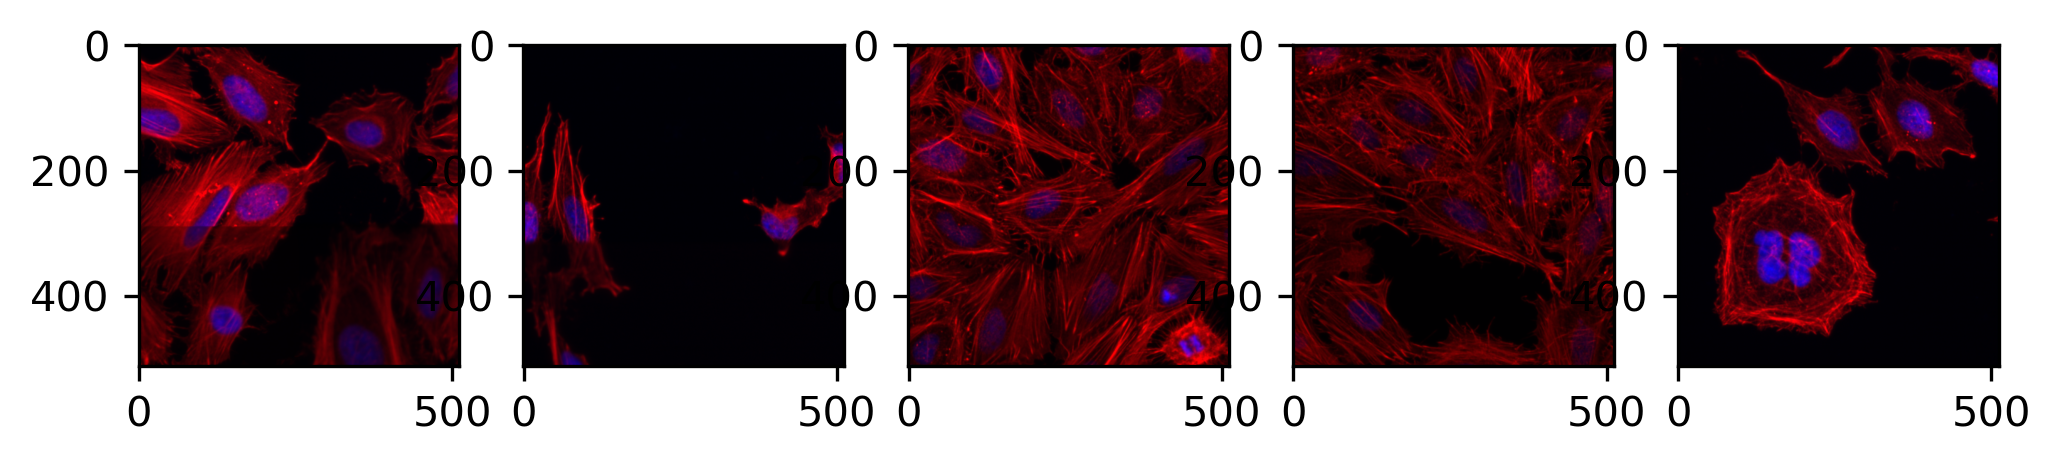

In [4]:
plt.figure(figsize=(8,4))
for k,img in enumerate(imgs[:-1]):
    plt.subplot(1,5,k+1)
    plt.imshow(img)

In [5]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
# ---------------------------------------------------------------------------------

# imgs_2D = imgs[:-1]
from cellpose import models
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

channels = [1,3] # R=cytoplasm and B=nucleus
masks, flows, styles, diams = model.eval(imgs, diameter=150, flow_threshold=None, channels=channels)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 6 image(s)


C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]

time spent: running network 2.99s; flow+mask computation 0.80
estimated masks for 6 image(s) in 3.88 sec
>>>> TOTAL TIME 3.88 sec


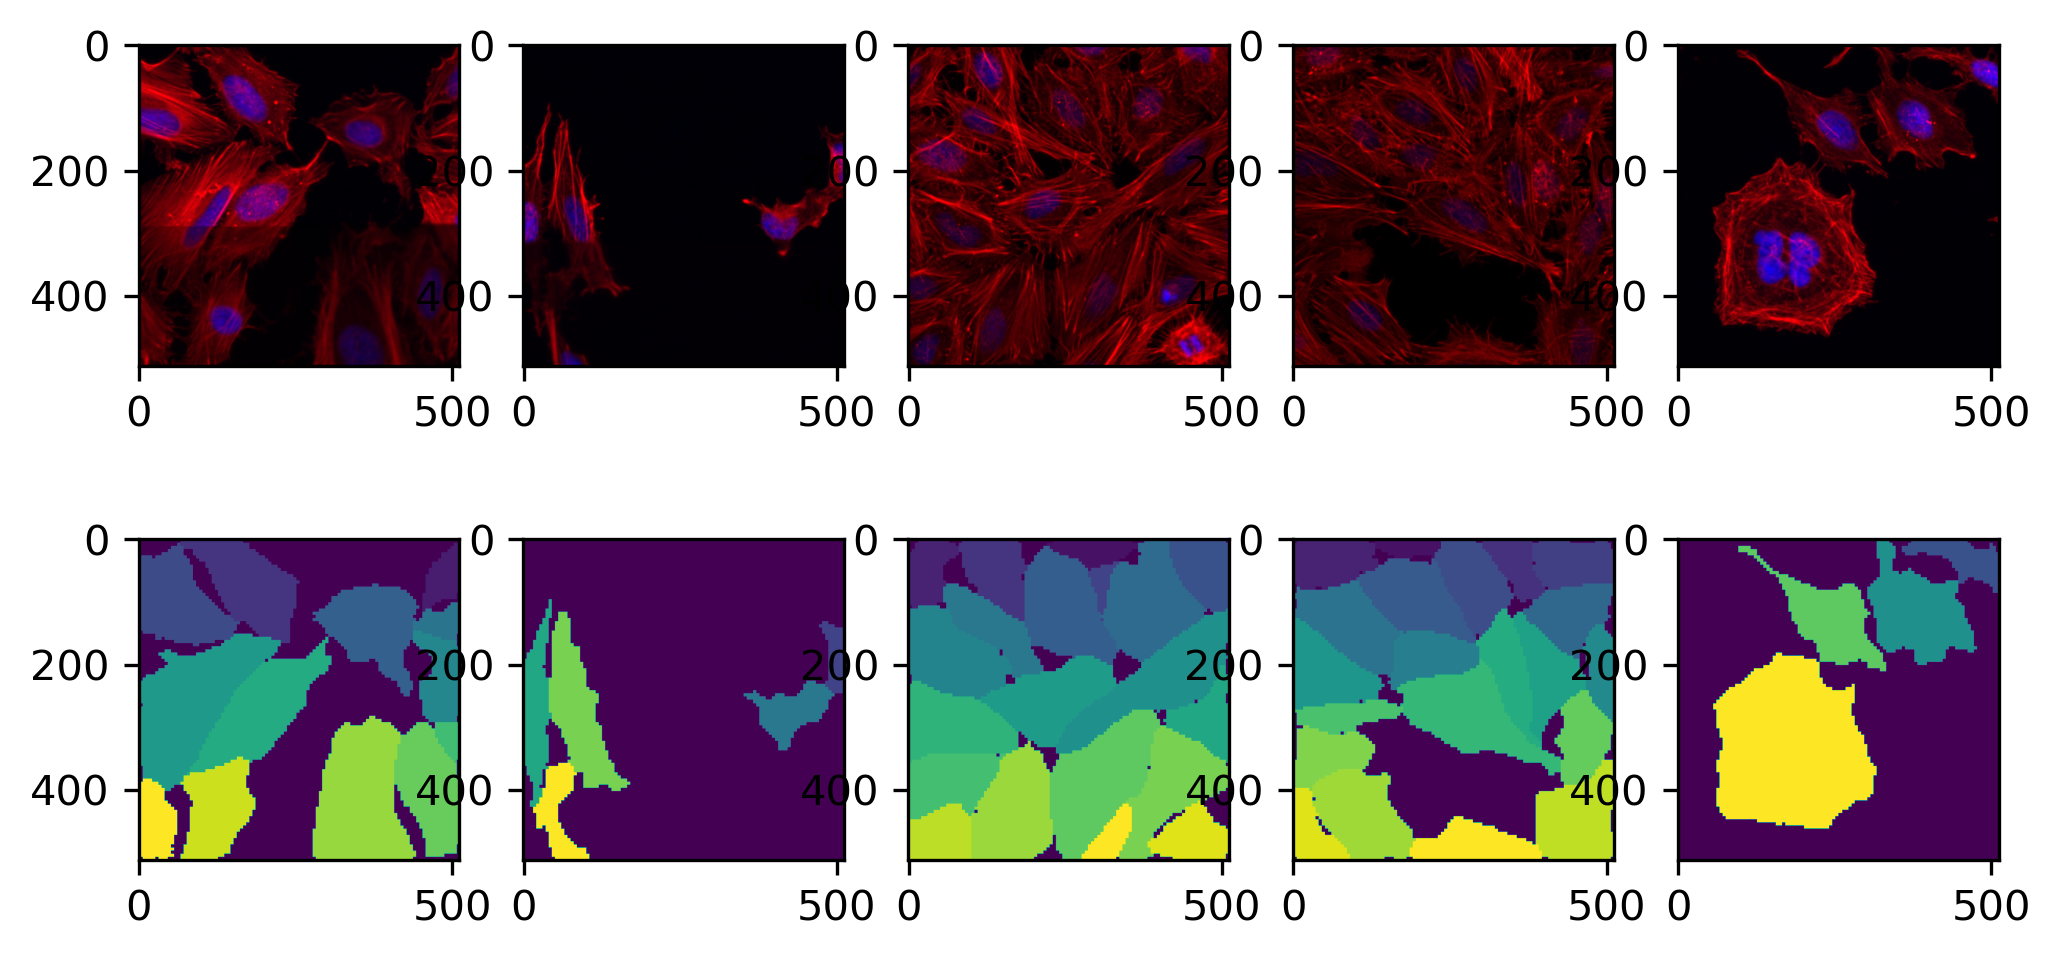

In [6]:
plt.figure(figsize=(8,4))
for k,img in enumerate(imgs[:-1]):
    plt.subplot(2,5,k+1)
    plt.imshow(img)
    plt.subplot(2,5,k+6)
    plt.imshow(masks[k])

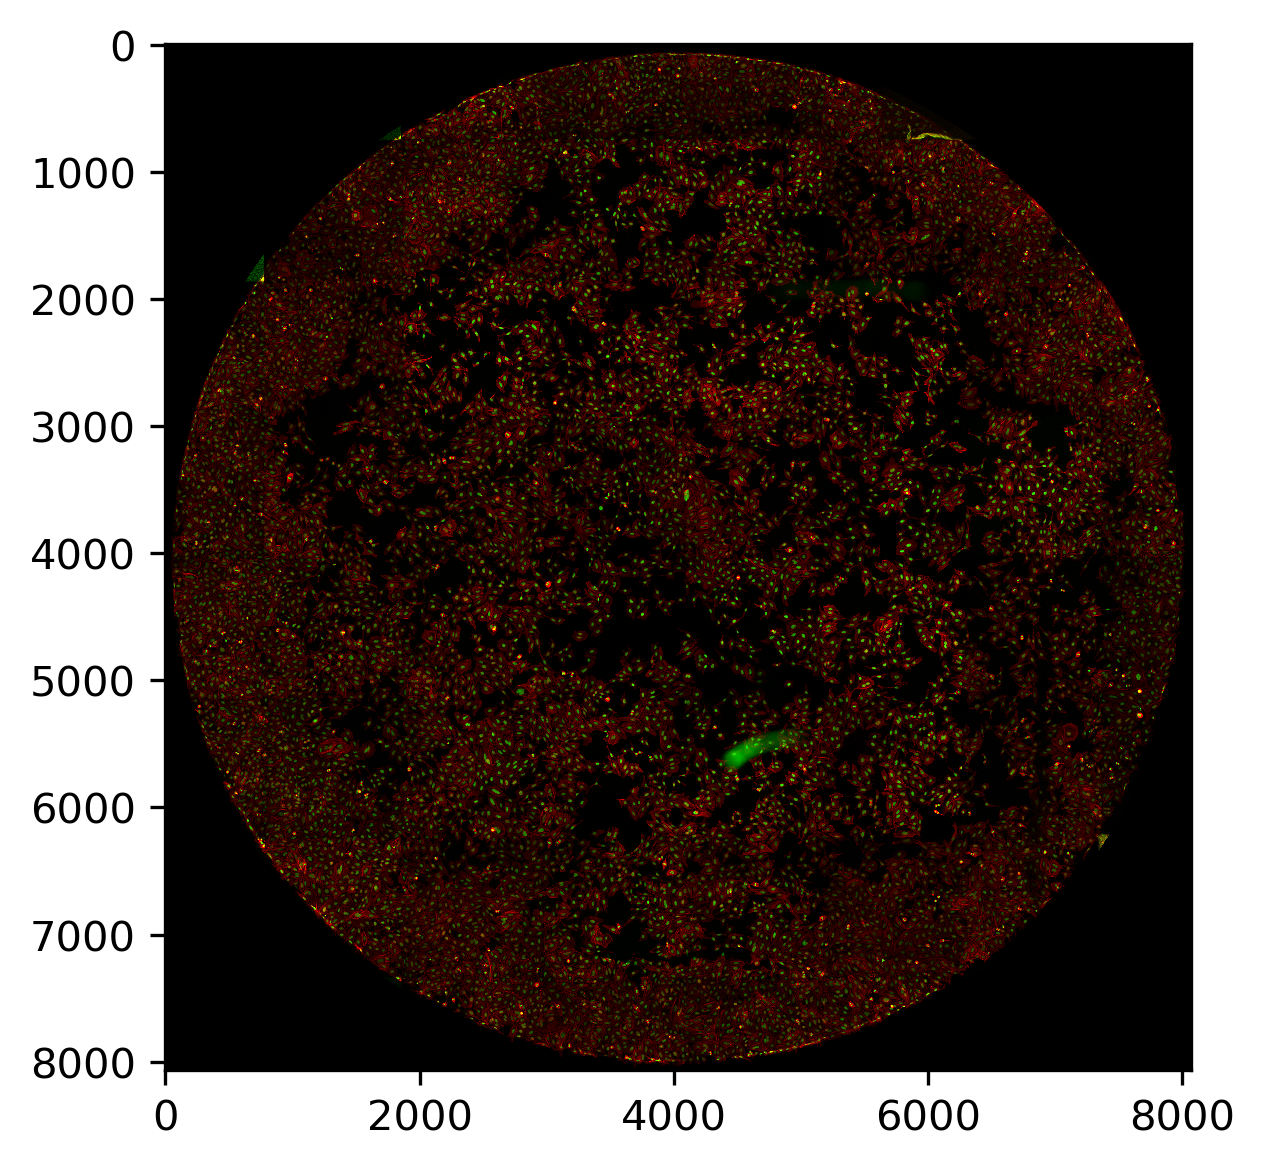

In [11]:
experiment = 'WKS024'
magnification = '10x'
well = 'B02'
fused_path = os.path.join('Experiments', experiment, magnification, well, well+'_fused_RGB.tif')
fused = io.imread(fused_path)
io.imshow(fused)

In [12]:
fused.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [36]:
def crop_img(fused, w, ol):
    '''
    This function find the limits of an image dimension s.t. tiles fit inside it.
    The operation is done for one dimension only.
    P = number of pixels of the input image, in one dimension.
    w = width of tile (e.g. 512).
    ol = overlap of tiles (e.g. 100 pixels)
    '''
    
    N,M,C = fused.shape
    
    numtiles = (M - w) / (w - ol) + 1
    numtiles_rounded = np.ceil(numtiles)
    new_M = numtiles_rounded * (w - ol) + w
    size_difference = new_M - M
    
    add1 = np.ceil(size_difference / 2)
    add2 = np.floor(size_difference / 2)
    
    new_fused = np.concatenate((np.zeros((N,add1)),fused,np.zeros((N,add2))))
    
    return new_fused


def create_tiles(cropped_ch, xnumtiles, ynumtiles, w, ol):
    '''
    Create tiles with overlap.
    '''
    xtile_positions = np.arange(0, xnumtiles) * (w - ol)
    ytile_positions = np.arange(0, ynumtiles) * (w - ol)
    
    tiles = []
    for x in xtile_positions:
        for y in ytile_positions:
            x = int(x)
            y = int(y)
            tiles.append(cropped_ch[y:y+w, x:x+w, :])
            
    return tiles

In [37]:
new_fused=crop_img(fused, w, ol)
new_fused.shape

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [23]:
w = 512
ol = 100
N,M,C = fused.shape
    
xmin, xmax, xnumtiles = crop_img(M, w, ol)
ymin, ymax, ynumtiles = crop_img(N, w, ol)

> <ipython-input-22-a1c2979b2b80>(12)crop_img()
     10     numtiles = (P - w) / (w - ol) + 1
     11     breakpoint()
---> 12     numtiles_rounded = np.floor(numtiles)
     13 
     14     num_included = numtiles_rounded * (w - ol) + w

ipdb> numtiles 
19.33009708737864
ipdb> exit


BdbQuit: 